<a href="https://colab.research.google.com/github/MedCoder-Edwin/Biomarkers-for-depression-in-EEG-signals/blob/main/Biomarkers_for_depression_in_EEG_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline analisis de conectividad funcional EEG:
- lectura + graficado crudo
- notch 60 Hz, bandpass 1-40 Hz, referencia promedio
- ICA (detección manual de componentes a excluir)
- segmentación en épocas fijas (2 s)
- conectividad espectral por bandas (delta/theta/alpha/beta/gamma)
- resultados devueltos en memoria + visualizaciones (connectivity circle y heatmap)
Requiere: mne, mne-connectivity, matplotlib, numpy
Instalar (si falta): !pip install mne mne-connectivity

In [2]:
!pip install mne
!pip install  mne-connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.5 MB/s eta 0:00:00


In [3]:
import os
from typing import Dict, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.io import read_raw_edf
from mne.preprocessing import ICA
from mne_connectivity import spectral_connectivity_epochs

In [4]:
# --------------------------
# Parámetros
# --------------------------
NOTCH_FREQ = 60.0          # Notch en 60 Hz según tu petición
BP_LOWER = 1.0             # Bandpass low cut (Hz)
BP_UPPER = 40.0            # Bandpass high cut (Hz)
RESAMPLE_SFREQ = 250.0     # Re-muestreo opcional (None para mantener)
EPOCH_DURATION = 2.0       # Duración de cada época (s)
EPOCH_OVERLAP = 0.0        # Overlap entre épocas (s)
ICA_N_COMPONENTS = 0.99    # varianza explicada (o int para número fijo)
ICA_METHOD = "fastica"
ICA_RANDOM_STATE = 42

# Bandas definidas
BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 12.0),
    "beta":  (12.0, 30.0),
    "gamma": (30.0, 40.0)
}


In [5]:
# --------------------------
# Utilidades: carga y graficado
# --------------------------
def load_and_plot_raw(edf_path: str,
                      montage_name: str = "standard_1020",
                      preload: bool = True,
                      plot_duration: float = 10.0) -> mne.io.Raw:
    """Cargar EDF, aplicar montaje estándar (si posible) y graficar señal cruda."""
    if not os.path.exists(edf_path):
        raise FileNotFoundError(f"No se encontró {edf_path}")
    raw = read_raw_edf(edf_path, preload=preload, verbose=False)

    # intentar aplicar montaje estándar 10-20
    try:
        montage = mne.channels.make_standard_montage(montage_name)
        raw.set_montage(montage, match_case=False, on_missing="warn")
    except Exception:
        print("Warning: no se pudo aplicar montaje estándar; se continúa sin él.")

    print(f"Archivo cargado: {edf_path}")
    print(f"Canales: {len(raw.ch_names)} | sfreq: {raw.info['sfreq']} Hz")
    # Graficar primera parte de la señal cruda (interactive en notebook)
    raw.plot(n_channels=10, duration=plot_duration, show=True, block=False)
    return raw

In [6]:
# --------------------------
# Preprocesado: notch + bandpass + referencia + resample
# --------------------------
def preprocess_raw(raw: mne.io.Raw,
                   notch_freq: float = NOTCH_FREQ,
                   l_freq: Optional[float] = BP_LOWER,
                   h_freq: Optional[float] = BP_UPPER,
                   resample_sfreq: Optional[float] = RESAMPLE_SFREQ) -> mne.io.Raw:
    """Aplicar notch, bandpass, referencia promedio y opcional resample."""
    picks_eeg = mne.pick_types(raw.info, eeg=True, eog=False, meg=False, exclude='bads')
    # Notch
    if notch_freq:
        raw.notch_filter(freqs=[notch_freq], picks=picks_eeg, method='spectrum_fit', verbose=False)
        print(f"Notch aplicado en {notch_freq} Hz.")
    # Bandpass
    if l_freq is not None or h_freq is not None:
        raw.filter(l_freq=l_freq, h_freq=h_freq, picks=picks_eeg, fir_design='firwin', verbose=False)
        print(f"Bandpass aplicado: {l_freq} - {h_freq} Hz.")
    # Re-referencia promedio
    try:
        raw.set_eeg_reference('average', projection=False, verbose=False)
        print("Referencia promedio aplicada.")
    except Exception:
        print("Warning: falla al aplicar referencia promedio.")
    # Resample si se solicita
    if resample_sfreq is not None:
        raw.resample(resample_sfreq, npad='auto', verbose=False)
        print(f"Re-muestreo a {resample_sfreq} Hz.")
    return raw

In [7]:
# --------------------------
# ICA: ajuste y funciones de soporte para selección manual
# --------------------------
def fit_ica(raw: mne.io.Raw,
            n_components=ICA_N_COMPONENTS,
            method: str = ICA_METHOD,
            random_state: int = ICA_RANDOM_STATE) -> ICA:
    """Ajustar ICA sobre datos preprocesados (solo canales EEG)."""
    picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
    ica = ICA(n_components=n_components, method=method, random_state=random_state, verbose=False)
    ica.fit(raw, picks=picks, verbose=False)
    print(f"ICA ajustada: {ica.n_components_} componentes.")
    return ica

def plot_ica_components(ica: ICA, raw: mne.io.Raw, n_components: int = 20):
    # plot sources superpuestos a raw (trazas) para inspección
    ica.plot_sources(raw, show=True)


def apply_ica_exclude(ica: ICA, raw: mne.io.Raw, exclude: List[int]) -> mne.io.Raw:
    """Aplicar ICA excluyendo la lista de índices de componentes que el usuario especifica."""
    ica.exclude = list(exclude)
    print(f"Componentes a excluir: {ica.exclude}")
    raw_corrected = ica.apply(raw.copy(), exclude=ica.exclude, verbose=False)
    return raw_corrected

In [8]:
# --------------------------
# Epoching: épocas fijas (no hay eventos)
# --------------------------
def make_fixed_epochs(raw: mne.io.Raw, duration: float = EPOCH_DURATION, overlap: float = EPOCH_OVERLAP) -> mne.Epochs:
    """Segmentar raw en ventanas fijas (útil cuando no hay eventos)."""
    epochs = mne.make_fixed_length_epochs(raw, duration=duration, overlap=overlap, preload=True, verbose=False)
    print(f"Épocas creadas: {len(epochs)} | duración: {duration}s | overlap: {overlap}s")
    return epochs

In [9]:
# --------------------------
# Conectividad espectral por bandas
# --------------------------
def compute_connectivity_by_band(epochs: mne.Epochs,
                                 bands: Dict[str, Tuple[float, float]] = BANDS,
                                 mode: str = 'fourier',
                                 method: str = 'wpli',
                                 faverage: bool = True,
                                 n_jobs: int = 1) -> Dict[str, Dict]:
    """
    Calcula conectividad espectral para cada banda.
    Devuelve diccionario de la forma:
      { 'alpha': {'con_object': SpectralConnectivity object, 'freqs': freqs, ...}, ... }
    """
    results = {}
    sfreq = epochs.info['sfreq']
    for band_name, (fmin, fmax) in bands.items():
        print(f"Calculando conectividad para banda {band_name}: {fmin}-{fmax} Hz ...")
        # spectral_connectivity_epochs now returns a SpectralConnectivity object
        connectivity_object = spectral_connectivity_epochs(
            epochs, method=method, mode=mode, sfreq=sfreq,
            fmin=fmin, fmax=fmax, faverage=faverage, n_jobs=n_jobs, verbose=False
        )
        results[band_name] = {
            'con_object': connectivity_object, # Store the object
            'freqs': connectivity_object.freqs,
            'n_epochs': connectivity_object.n_epochs,
        }
        # Access data via get_data and get shape
        print(f"  -> hecho. con_object.get_data().shape = {connectivity_object.get_data(output='dense').shape}")
    return results

In [10]:
# --------------------------
# Visualización de la conectividad
# --------------------------
def con_to_matrix(con_object, n_channels: int):
    """
    Convierte un SpectralConnectivity object a una matriz cuadrada (n_channels x n_channels).
    """
    # Get the data as a dense numpy array
    arr = con_object.get_data(output='dense')

    if arr.ndim == 3:
        # (n_channels, n_channels, n_freqs) -> average over frequencies
        if arr.shape[2] > 1:
            mat = arr.mean(axis=2)
        else:
            mat = arr[:, :, 0]
    elif arr.ndim == 2:
        # (n_pairs, n_freqs) -> take freq average and reconstruct upper triangle
        avg_over_freq = arr.mean(axis=1)  # (n_pairs,)
        # reconstruct symmetric matrix from upper triangle (standard in MNE)
        mat = np.zeros((n_channels, n_channels))
        iu = np.triu_indices(n_channels, k=1)
        if avg_over_freq.size != iu[0].size:
            # If size doesn't match, return empty matrix for now.
             raise ValueError("No se pudo mapear vectorizado 'con' a matriz cuadrada: tamaño no coincide.")

        mat[iu] = avg_over_freq
        mat = mat + mat.T
    else:
        raise ValueError(f"Formato inesperado de 'con' con shape {arr.shape}")
    return mat


def plot_connectivity_matrix(mat: np.ndarray, ch_names: List[str], title: str = ""):
    """Mostrar heatmap de la matriz de conectividad."""
    plt.figure(figsize=(8, 6))
    plt.imshow(mat, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xticks(np.arange(len(ch_names)), ch_names, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(ch_names)), ch_names, fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_connectivity(con_object, ch_names: List[str], title: str = ""):
        mat = con_to_matrix(con_object, len(ch_names))
        plot_connectivity_matrix(mat, ch_names, title=title)

In [11]:
# --------------------------
# Pipeline principal de ejemplo (ejecución)
# --------------------------
def run_pipeline(edf_path: str,
                 do_plot_raw: bool = True,
                 ica_show_n_components: int = 20,
                 ica_exclude_list: Optional[List[int]] = None,
                 epoch_duration: float = EPOCH_DURATION,
                 epoch_overlap: float = EPOCH_OVERLAP,
                 compute_bands: Dict[str, Tuple[float, float]] = BANDS,
                 method_connectivity: str = 'wpli',
                 mode_connectivity: str = 'fourier',
                 n_jobs: int = 1) -> Dict:
    """
    Ejecuta pipeline completo y devuelve un diccionario con resultados:
      {'raw': raw_original, 'raw_pre': raw_preproc, 'ica': ica, 'raw_clean': raw_clean,
       'epochs': epochs, 'connectivity': connectivity_results}
    IMPORTANTE: Si ica_exclude_list es None -> se muestra la gráfica y NO excluye componentes.
    """
    # 1) Carga y graficado
    raw = load_and_plot_raw(edf_path, preload=True, plot_duration=6.0 if do_plot_raw else 0.0)

    # 2) Preprocesado
    raw_pre = preprocess_raw(raw, notch_freq=NOTCH_FREQ, l_freq=BP_LOWER, h_freq=BP_UPPER, resample_sfreq=RESAMPLE_SFREQ)

    # 3) ICA ajuste
    ica = fit_ica(raw_pre, n_components=ICA_N_COMPONENTS, method=ICA_METHOD, random_state=ICA_RANDOM_STATE)
    # Mostrar componentes para inspección manual
    plot_ica_components(ica, raw_pre, n_components=ica_show_n_components)
    # Si el usuario ya definió lista de exclusión, aplicarla; si no, retorna la señal sin aplicar
    if ica_exclude_list:
        raw_clean = apply_ica_exclude(ica, raw_pre, ica_exclude_list)
        print("ICA aplicada con exclusión manual.")
    else:
        raw_clean = raw_pre.copy()
        print("No se excluyeron componentes (ica_exclude_list es None).")

    # 4) Epoching fijo
    epochs = make_fixed_epochs(raw_clean, duration=epoch_duration, overlap=epoch_overlap)

    # 5) Conectividad por banda
    connectivity = compute_connectivity_by_band(epochs, bands=compute_bands, mode=mode_connectivity, method=method_connectivity, n_jobs=n_jobs)

    # 6) Convertir y plot resultados por banda (heatmap + circle)
    ch_names = [ch for ch in epochs.ch_names]
    n_ch = len(ch_names)
    connectivity_matrices = {}
    for band, res in connectivity.items():
        try:
            # Pass the connectivity object to con_to_matrix
            mat = con_to_matrix(res['con_object'], n_channels=n_ch)
            connectivity_matrices[band] = mat
            title = f"Conectividad ({method_connectivity}) - {band} ({compute_bands[band][0]}-{compute_bands[band][1]} Hz)" # Fixed: use compute_bands
            print(f"Ploteando banda {band} ...")
            plot_connectivity_matrix(mat, ch_names, title=title + " (heatmap)")
        except Exception as e:
            print(f"No se pudo convertir/plotear banda {band}: {e}")

    # Devolver resultados en memoria
    return {
        'raw': raw,
        'raw_pre': raw_pre,
        'ica': ica,
        'raw_clean': raw_clean,
        'epochs': epochs,
        'connectivity_raw': connectivity,      # resultado tal cual de mne_connectivity
        'connectivity_matrices': connectivity_matrices  # matrices n_ch x n_ch promediadas por freq
    }

/tmp/ipython-input-16663478.py:16: RuntimeWarning: DigMontage is only a subset of info. There are 18 channel positions not present in the DigMontage. The channels missing from the montage are:

['FP1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FZ-CZ', 'CZ-PZ', 'FP2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, match_case=False, on_missing="warn")


Archivo cargado: healthy_subject.edf
Canales: 18 | sfreq: 250.0 Hz


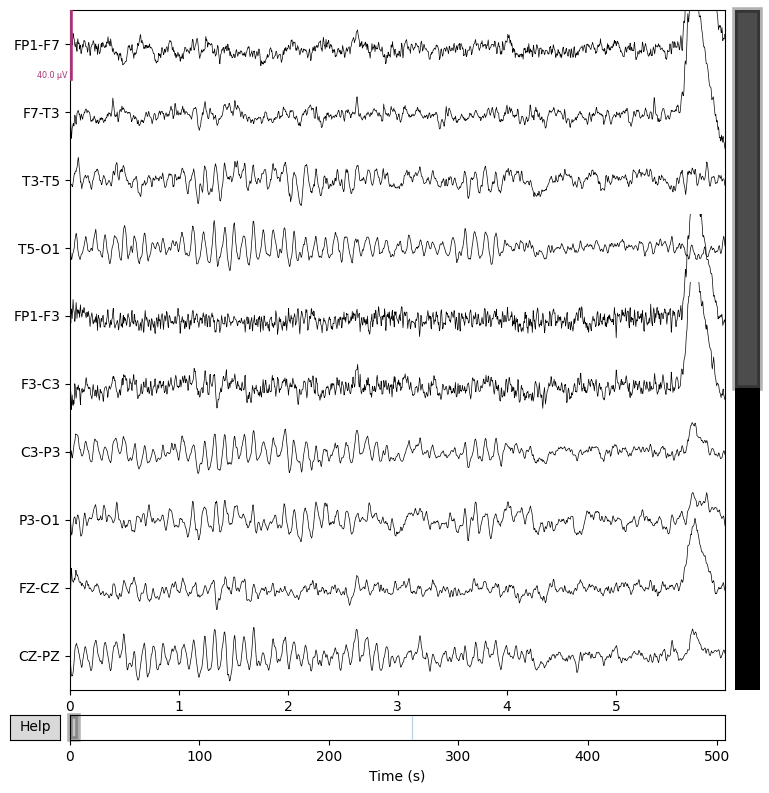

Notch aplicado en 60.0 Hz.
Bandpass aplicado: 1.0 - 40.0 Hz.
Referencia promedio aplicada.
Re-muestreo a 250.0 Hz.
ICA ajustada: 13 componentes.
Creating RawArray with float64 data, n_channels=13, n_times=126500
    Range : 0 ... 126499 =      0.000 ...   505.996 secs
Ready.


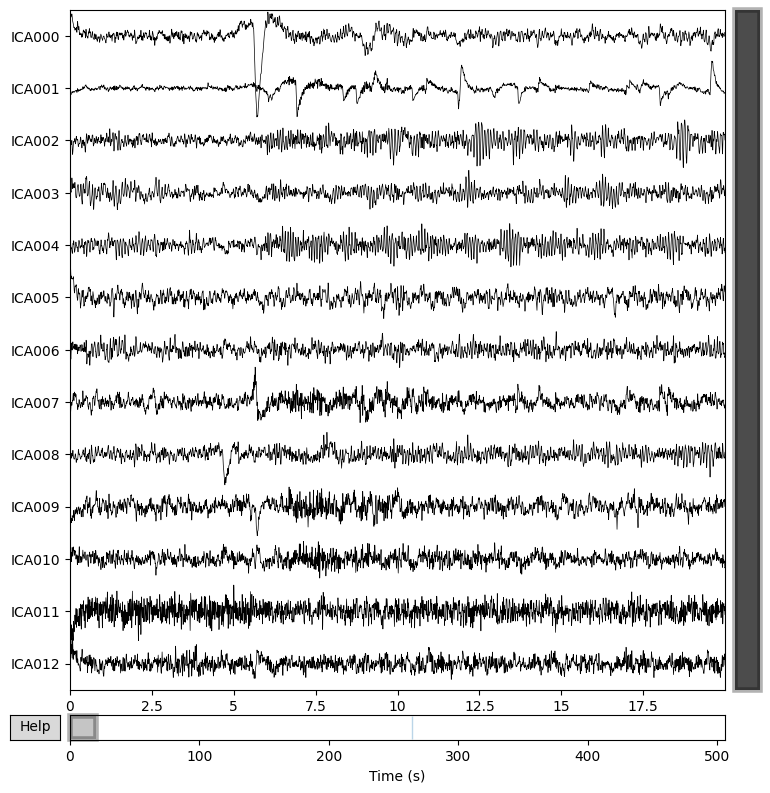

Componentes a excluir: [0, 1]
ICA aplicada con exclusión manual.
Épocas creadas: 253 | duración: 2.0s | overlap: 0.0s
Calculando conectividad para banda delta: 1.0-4.0 Hz ...


/tmp/ipython-input-2526951054.py:20: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  connectivity_object = spectral_connectivity_epochs(


  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda theta: 4.0-8.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda alpha: 8.0-12.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda beta: 12.0-30.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda gamma: 30.0-40.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Ploteando banda delta ...


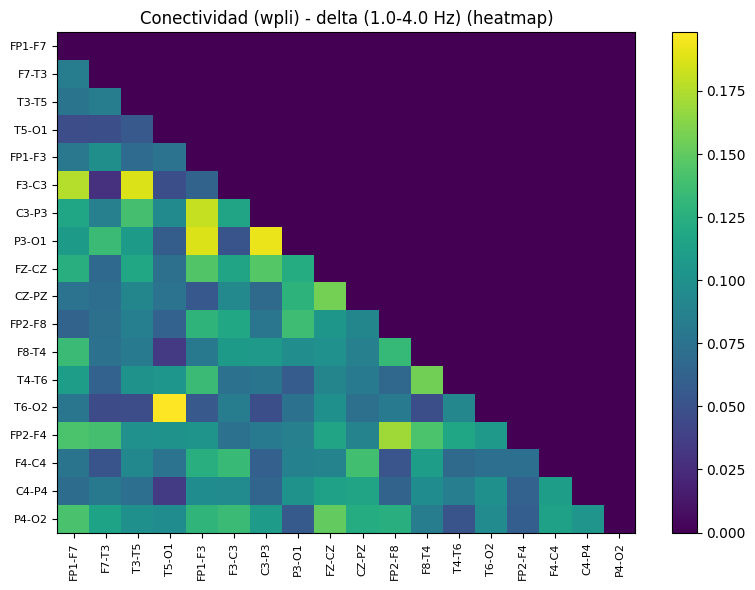

Ploteando banda theta ...


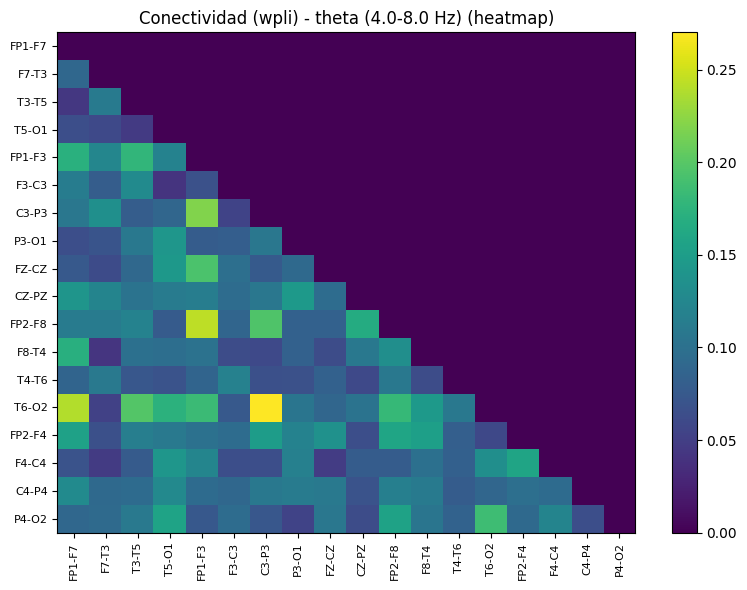

Ploteando banda alpha ...


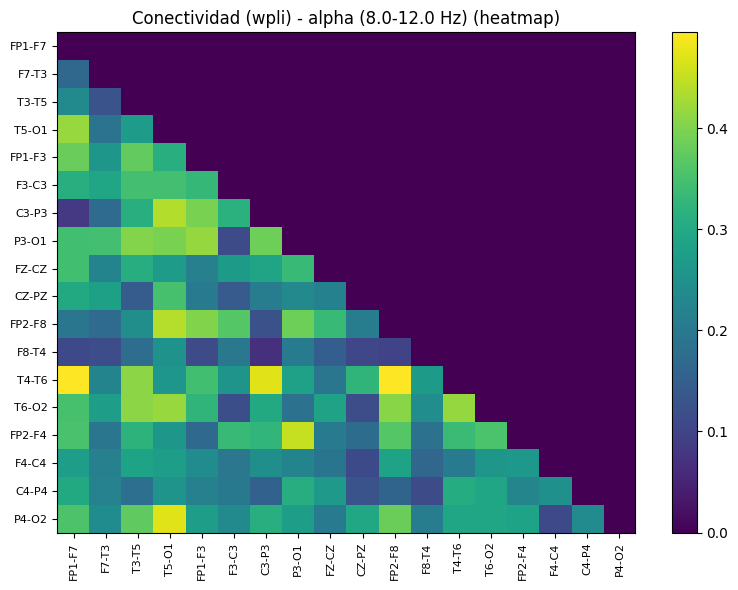

Ploteando banda beta ...


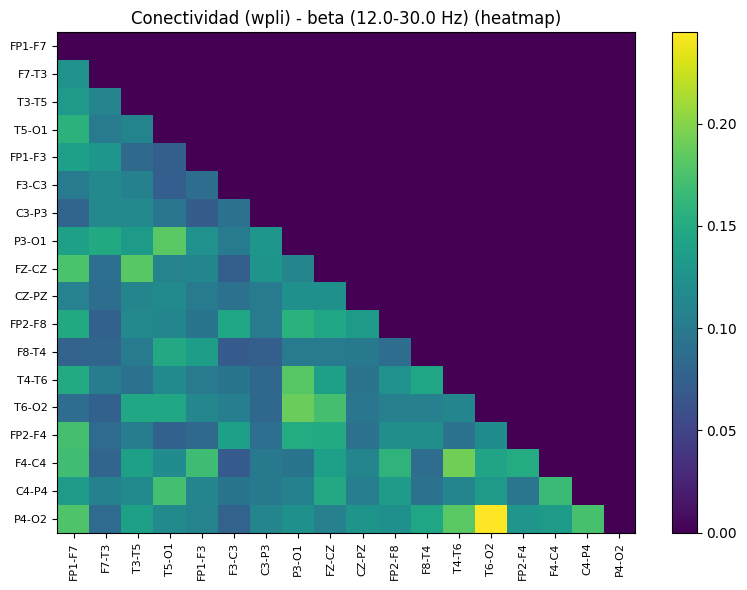

Ploteando banda gamma ...


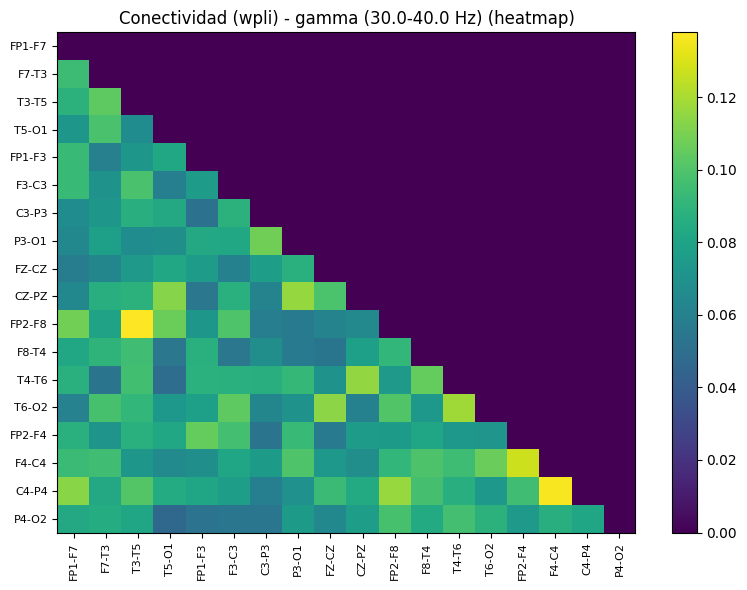

Pipeline finalizado. Bandas calculadas: ['delta', 'theta', 'alpha', 'beta', 'gamma']


In [14]:
# --------------------------
# Persona sana:
# --------------------------
if __name__ == "__main__":
    # Cambia la ruta al archivo EDF real en tu entorno
    EDF_PATH = "healthy_subject.edf"  # <- reemplaza con tu archivo
    # Si quieres excluir componentes inmediatamente (p.e. [0,2,5]) defines ICA_EXCLUDE_LIST aquí.
    # Si lo dejas None, el script mostrará las figuras y no excluirá componentes hasta que decidas.
    ICA_EXCLUDE_LIST = [0,1]  # Ej: [0, 2]  <- pon aquí la lista si ya la conoces

    results = run_pipeline(EDF_PATH, do_plot_raw=True, ica_show_n_components=20, ica_exclude_list=ICA_EXCLUDE_LIST)
    # results['connectivity_matrices'] contiene las matrices por banda en memoria
    print("Pipeline finalizado. Bandas calculadas:", list(results['connectivity_matrices'].keys()))

/tmp/ipython-input-16663478.py:16: RuntimeWarning: DigMontage is only a subset of info. There are 18 channel positions not present in the DigMontage. The channels missing from the montage are:

['FP1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FZ-CZ', 'CZ-PZ', 'FP2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, match_case=False, on_missing="warn")


Archivo cargado: depressed_subject.edf
Canales: 18 | sfreq: 250.0 Hz


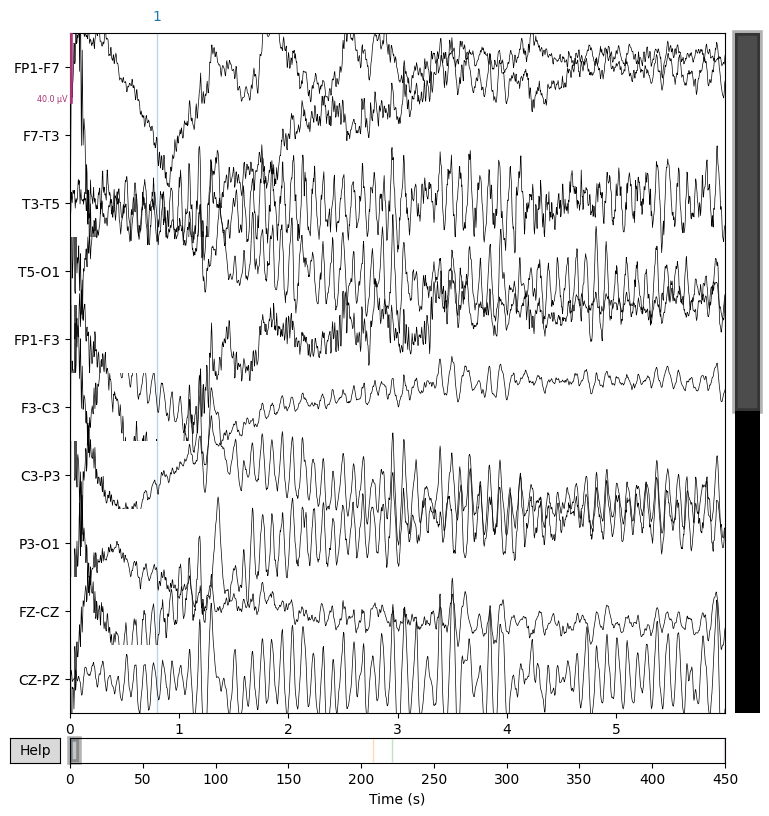

Notch aplicado en 60.0 Hz.
Bandpass aplicado: 1.0 - 40.0 Hz.
Referencia promedio aplicada.
Re-muestreo a 250.0 Hz.
ICA ajustada: 8 componentes.
Creating RawArray with float64 data, n_channels=8, n_times=112500
    Range : 0 ... 112499 =      0.000 ...   449.996 secs
Ready.


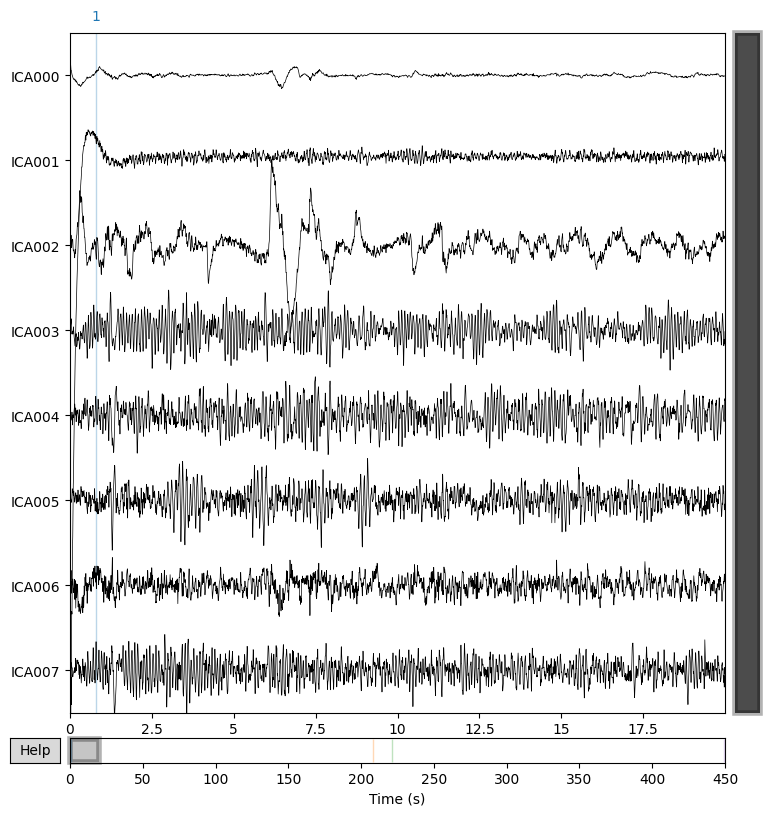

Componentes a excluir: [0, 2]
ICA aplicada con exclusión manual.
Épocas creadas: 225 | duración: 2.0s | overlap: 0.0s
Calculando conectividad para banda delta: 1.0-4.0 Hz ...


/tmp/ipython-input-2526951054.py:20: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  connectivity_object = spectral_connectivity_epochs(


  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda theta: 4.0-8.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda alpha: 8.0-12.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda beta: 12.0-30.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda gamma: 30.0-40.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Ploteando banda delta ...


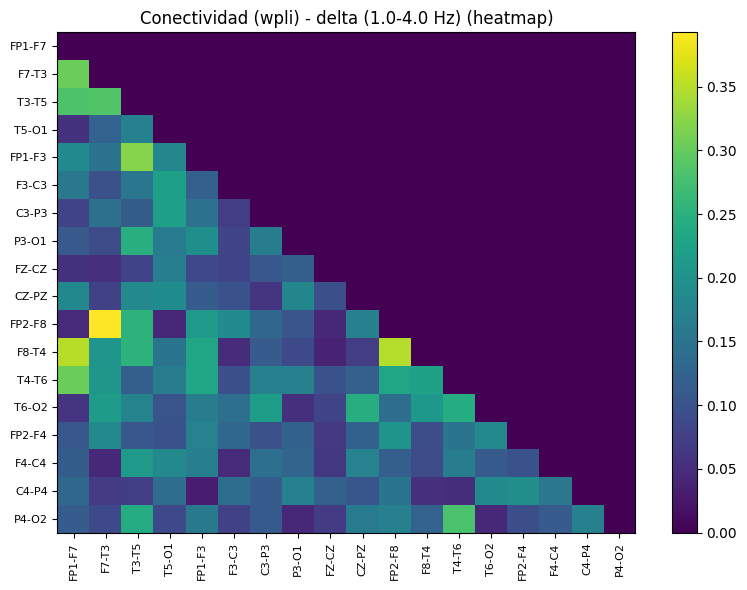

Ploteando banda theta ...


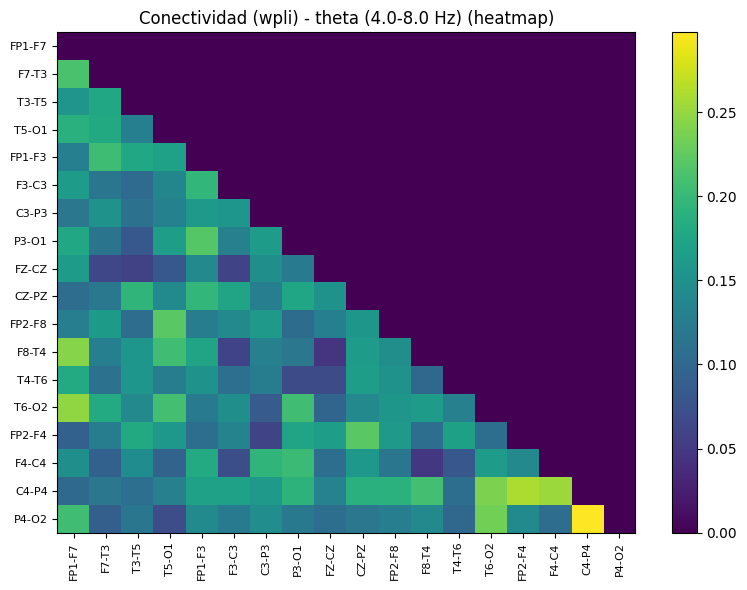

Ploteando banda alpha ...


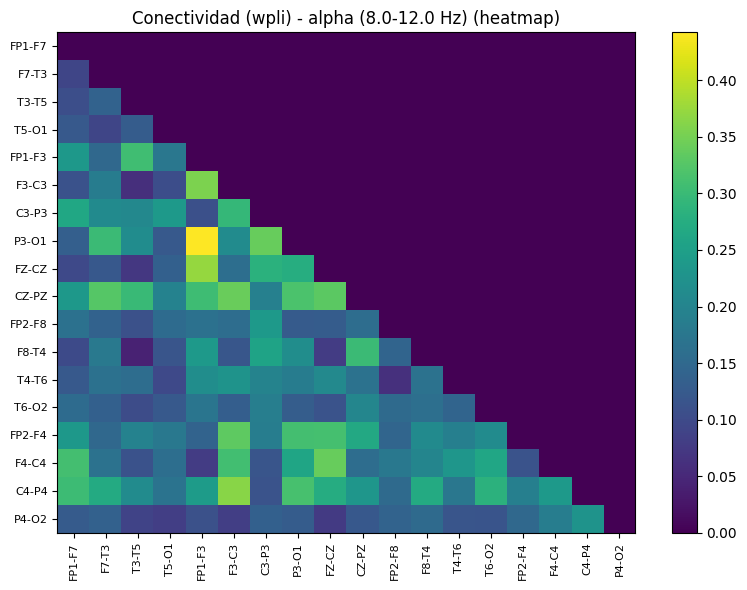

Ploteando banda beta ...


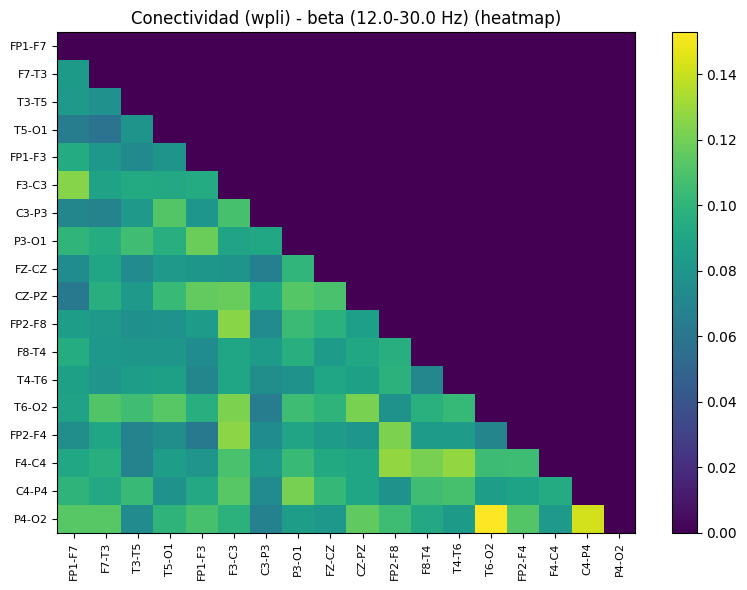

Ploteando banda gamma ...


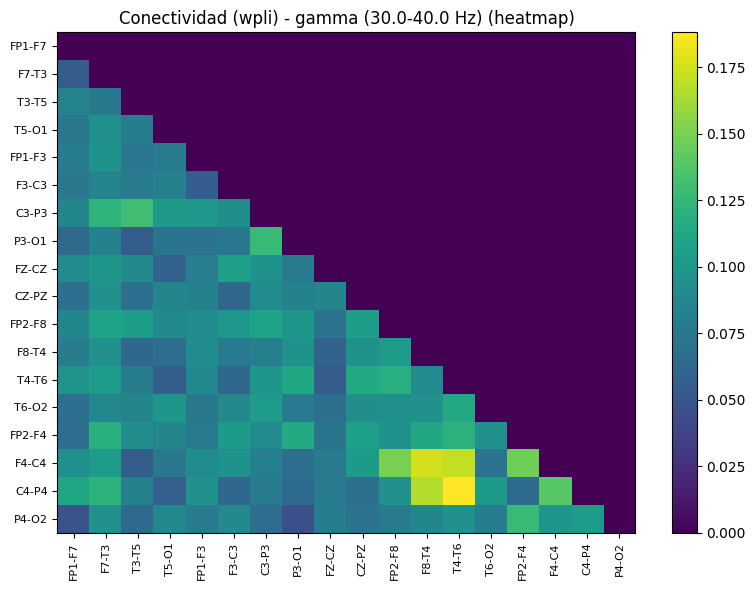

Pipeline finalizado. Bandas calculadas: ['delta', 'theta', 'alpha', 'beta', 'gamma']


In [16]:
# --------------------------
# Persona con depresion 1:
# --------------------------
if __name__ == "__main__":
    # Cambia la ruta al archivo EDF real en tu entorno
    EDF_PATH = "depressed_subject.edf"  # <- reemplaza con tu archivo
    # Si quieres excluir componentes inmediatamente (p.e. [0,2,5]) defines ICA_EXCLUDE_LIST aquí.
    # Si lo dejas None, el script mostrará las figuras y no excluirá componentes hasta que decidas.
    ICA_EXCLUDE_LIST = [0,2]  # Ej: [0, 2]  <- pon aquí la lista si ya la conoces

    results = run_pipeline(EDF_PATH, do_plot_raw=True, ica_show_n_components=20, ica_exclude_list=ICA_EXCLUDE_LIST)
    # results['connectivity_matrices'] contiene las matrices por banda en memoria
    print("Pipeline finalizado. Bandas calculadas:", list(results['connectivity_matrices'].keys()))

/tmp/ipython-input-16663478.py:16: RuntimeWarning: DigMontage is only a subset of info. There are 18 channel positions not present in the DigMontage. The channels missing from the montage are:

['FP1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FZ-CZ', 'CZ-PZ', 'FP2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, match_case=False, on_missing="warn")


Archivo cargado: depressed_subject2.edf
Canales: 18 | sfreq: 250.0 Hz


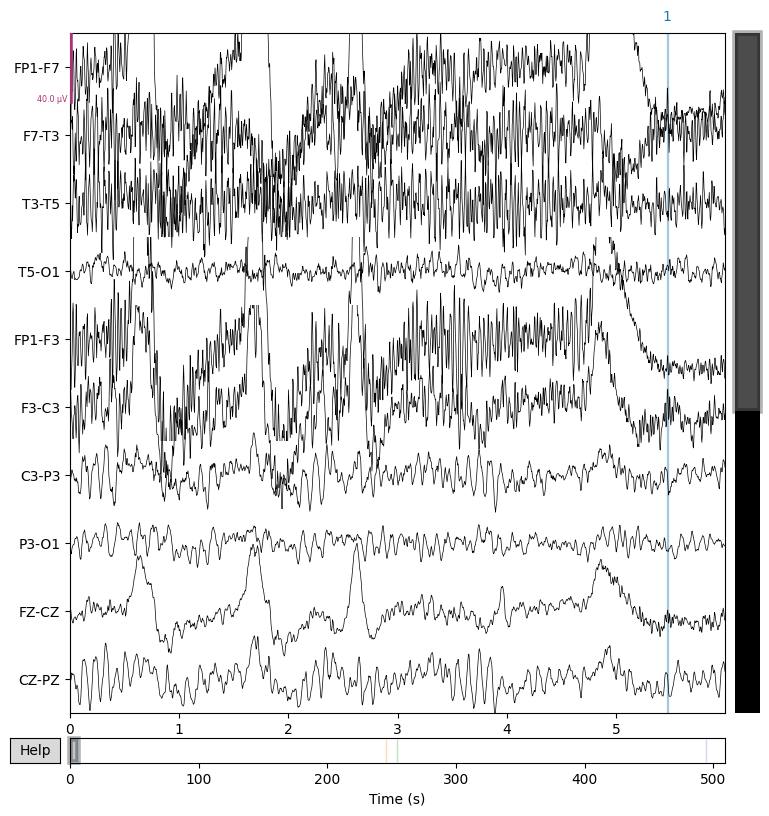

Notch aplicado en 60.0 Hz.
Bandpass aplicado: 1.0 - 40.0 Hz.
Referencia promedio aplicada.
Re-muestreo a 250.0 Hz.
ICA ajustada: 13 componentes.
Creating RawArray with float64 data, n_channels=13, n_times=127250
    Range : 0 ... 127249 =      0.000 ...   508.996 secs
Ready.


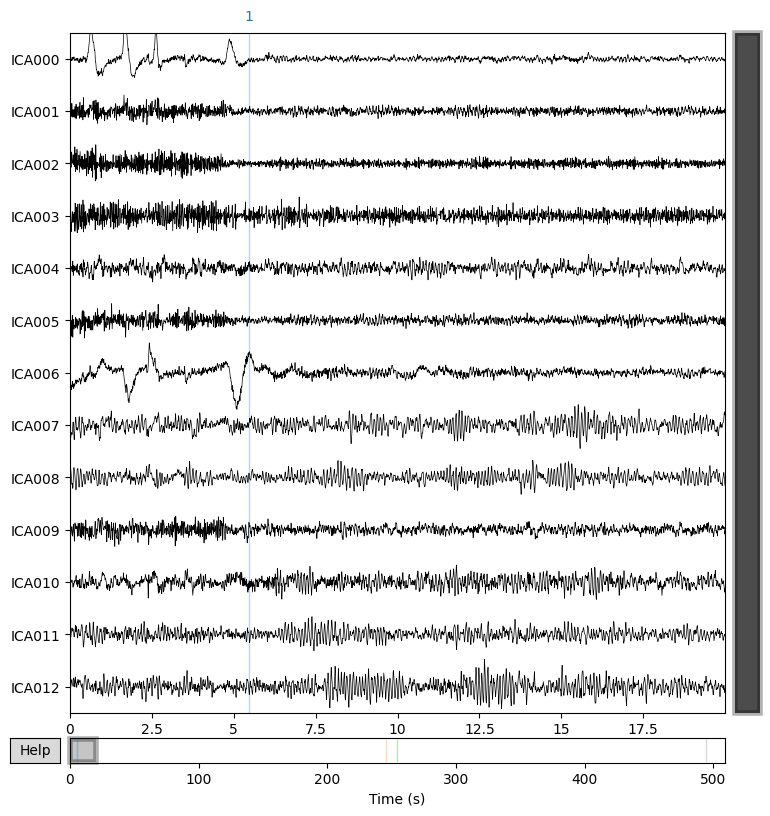

Componentes a excluir: [0, 6]
ICA aplicada con exclusión manual.
Épocas creadas: 254 | duración: 2.0s | overlap: 0.0s
Calculando conectividad para banda delta: 1.0-4.0 Hz ...


/tmp/ipython-input-2526951054.py:20: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  connectivity_object = spectral_connectivity_epochs(


  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda theta: 4.0-8.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda alpha: 8.0-12.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda beta: 12.0-30.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Calculando conectividad para banda gamma: 30.0-40.0 Hz ...
  -> hecho. con_object.get_data().shape = (18, 18, 1)
Ploteando banda delta ...


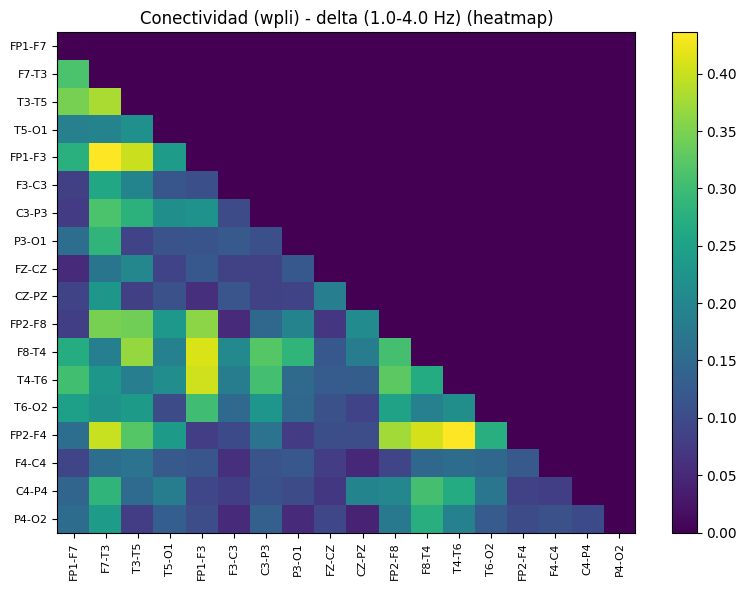

Ploteando banda theta ...


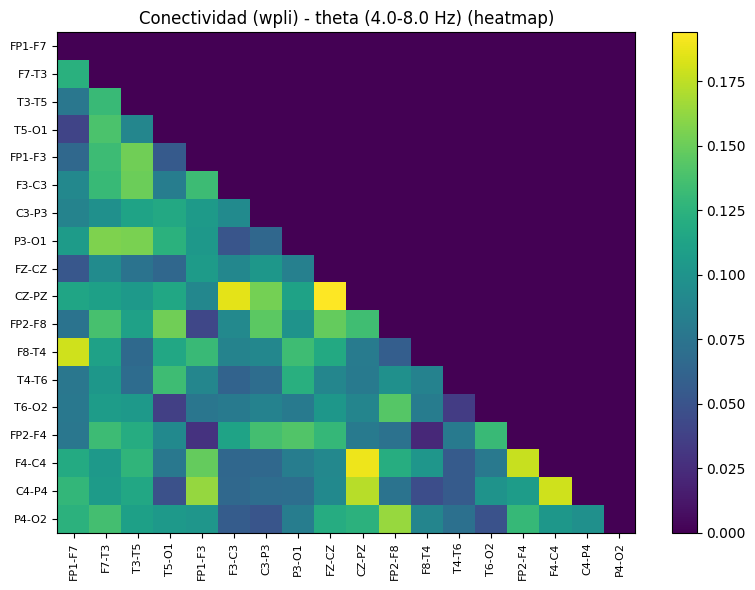

Ploteando banda alpha ...


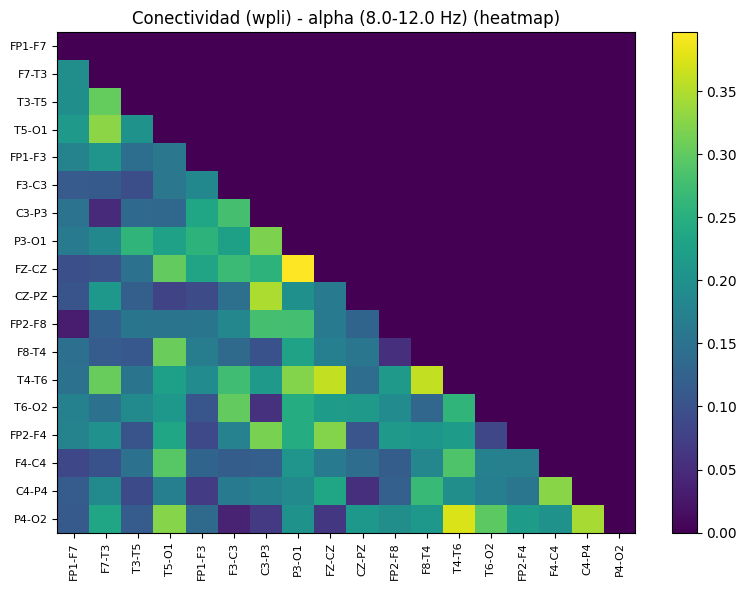

Ploteando banda beta ...


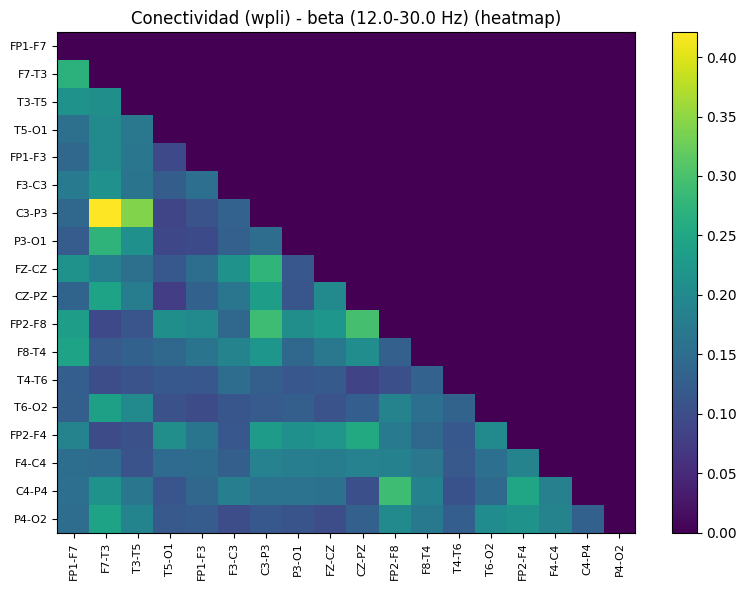

Ploteando banda gamma ...


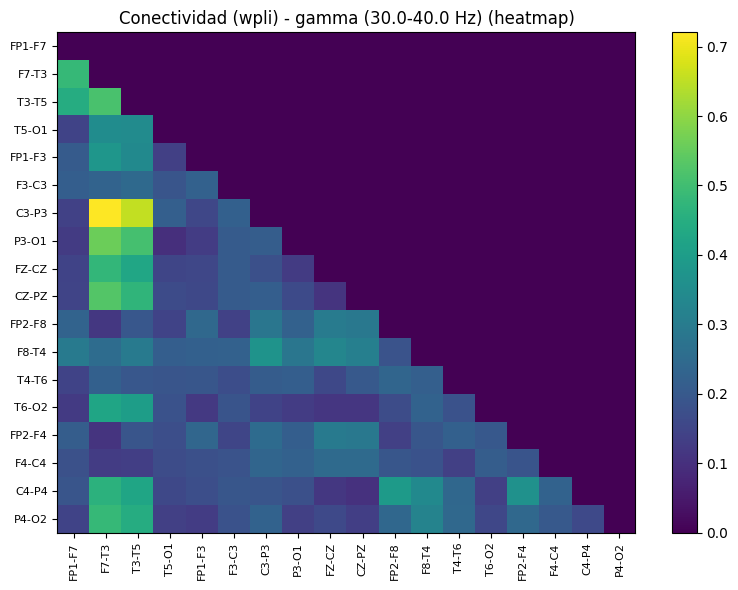

Pipeline finalizado. Bandas calculadas: ['delta', 'theta', 'alpha', 'beta', 'gamma']


In [18]:
# --------------------------
# Persona con depresion 2:
# --------------------------
if __name__ == "__main__":
    # Cambia la ruta al archivo EDF real en tu entorno
    EDF_PATH = "depressed_subject2.edf"  # <- reemplaza con tu archivo
    # Si quieres excluir componentes inmediatamente (p.e. [0,2,5]) defines ICA_EXCLUDE_LIST aquí.
    # Si lo dejas None, el script mostrará las figuras y no excluirá componentes hasta que decidas.
    ICA_EXCLUDE_LIST = [0,6]  # Ej: [0, 2]  <- pon aquí la lista si ya la conoces

    results = run_pipeline(EDF_PATH, do_plot_raw=True, ica_show_n_components=20, ica_exclude_list=ICA_EXCLUDE_LIST)
    # results['connectivity_matrices'] contiene las matrices por banda en memoria
    print("Pipeline finalizado. Bandas calculadas:", list(results['connectivity_matrices'].keys()))